In [48]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

df = pd.read_pickle("counter_dataset")
df.head(3)

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,...,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp
0,B000I68EL8,RZZQSQMVMPTW3,it feels so comfortable and I can wear it all ...,0,0,5,2017-07-27,True,False,0,...,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8
1,B000I68EL8,RZZI5BHNRQS5Z,Package came with the end missing from the box...,0,1,3,2017-12-24,True,False,0,...,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8
2,B000I68EL8,RZN7OFKFGQO0N,Birkenstock is an amazing shoe!!!! I wish I h...,0,0,5,2017-05-31,True,False,0,...,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8


In [49]:
print("There are ", df.shape[0], " rows and ", df.shape[1], "columns in the dataset.")
#Missing values in the dataset
df.isnull().sum()[df.isnull().sum()>0]

There are  359069  rows and  27 columns in the dataset.


body                             271
list_price                    346938
price_low                     102686
price_high                    102686
is_add_on                      81357
is_prime                       81357
is_prime_pantry                81357
is_prime_exclusive             81357
is_fresh                       81357
has_sns                        81357
offer_fulfiller               309694
offer_merchant                309694
lowest_price_new_condition    323020
brand                           1342
num_reviews                     2041
dtype: int64

There are way too many missing values in some of the columns. It is not advised to impute missing values when there are too many of them missing, As it will change the underlying distribution. __So, for the purpose of this analysis i will try to work only with the information present, and I will try to keep it simple.__

### For the purpose of this analysis i will consider grey market products == Counterfeit products

###  Q1. To what extent is the brand susceptible to counterfeiting/gray market selling?
To Answer this i will select the product who are available at >100% less than price high/low. I will consider those product as Grey Market Products. 

In [53]:
(df.price_high.equals(df.price_low))

True

Above two columns are identical we will drop one of them.


In [55]:
df.drop('price_low', axis = 1, inplace =True)

In [56]:
# prices that we can consider
prices = [x for x in df.columns if "price" in x]
prices

['list_price', 'price_high', 'lowest_price_new_condition']

In [57]:
print("Number of unique brands:", len(df["brand"].unique()))

Number of unique brands: 237


In [58]:
grouped_prices = df.groupby("asin").mean()[prices]
grouped_prices.head()

,list_price,price_high,lowest_price_new_condition
asin,,,
B000052YOX,NaN,NaN,NaN
B000052YQ2,NaN,NaN,NaN
B000052ZB5,NaN,NaN,NaN
B00005303E,NaN,NaN,NaN
B0000535RC,NaN,7.69,7.69


In [59]:
grouped_prices = grouped_prices.fillna(-1) #filling missing values with -1

In [60]:
grouped_prices["difference"] = grouped_prices["price_high"] / grouped_prices["lowest_price_new_condition"]
grouped_prices.head()

,list_price,price_high,lowest_price_new_condition,difference
asin,,,,
B000052YOX,-1.0,-1.00,-1.00,1.0
B000052YQ2,-1.0,-1.00,-1.00,1.0
B000052ZB5,-1.0,-1.00,-1.00,1.0
B00005303E,-1.0,-1.00,-1.00,1.0
B0000535RC,-1.0,7.69,7.69,1.0


In [61]:
peaked_prices = grouped_prices.sort_values(by="difference", ascending=False)
peaked_prices.head()

,list_price,price_high,lowest_price_new_condition,difference
asin,,,,
B079V3J3Y9,-1.0,3496.99,2.48,1410.076613
B007W1101I,-1.0,2095.76,1.54,1360.883117
B001TRF3G4,-1.0,4859.00,4.01,1211.720698
B01MTTSNVZ,-1.0,2799.88,2.45,1142.808163
B0072C8SQ2,-1.0,3229.74,3.05,1058.931148


Above dataframe shows product with higher difference between lowest price available and price_high (price observed)

In [62]:
# NOT SELECTION THE ONE WITH -1 VALUES, WE IMPUTED THAT VALUE ABOVE
peaked_prices = peaked_prices[(peaked_prices["difference"] != -1) 
              & (peaked_prices["price_high"] != -1)
              & (peaked_prices["lowest_price_new_condition"] != -1)]

In [63]:
# If the lowest price avialable is 100% less than list price
fake_sins = peaked_prices[peaked_prices["difference"] > 2].index.tolist()

In [64]:
unique_products = len(df.dropna(subset=(["price_high", "lowest_price_new_condition"]))["asin"].unique())

In [20]:
print("Total Products: {}".format(unique_products))
print("Total Fakes: {}".format(len(fake_sins)))
print("Percent: {0:.2f}%".format( (len(fake_sins)/unique_products) * 100))

Total Products: 611
Total Fakes: 81
Percent: 13.26%


13.26% average risk among all brands of being victim of grey market sellers.

## Q2 Factors that increase the risk of becoming target for gray marketing
Here i will subset two dataframes, 1 Authentic products 2nd one will contain Counterfeit product. Than will compare both of them

In [65]:
#Extracting Brand names and categories

brands = []
categories = []
for x in fake_sins:
    brands.append(df[df["asin"] == x]["brand"].iloc[0])
    categories.append(df[df["asin"] == x]["category"].iloc[0])

In [66]:
#Counting Brands and Categories

counter = list(Counter(brands).items())
counter.sort(key=lambda x: x[1], reverse=True)

counter_cat = list(Counter(categories).items())
counter_cat.sort(key=lambda x: x[1], reverse=True)

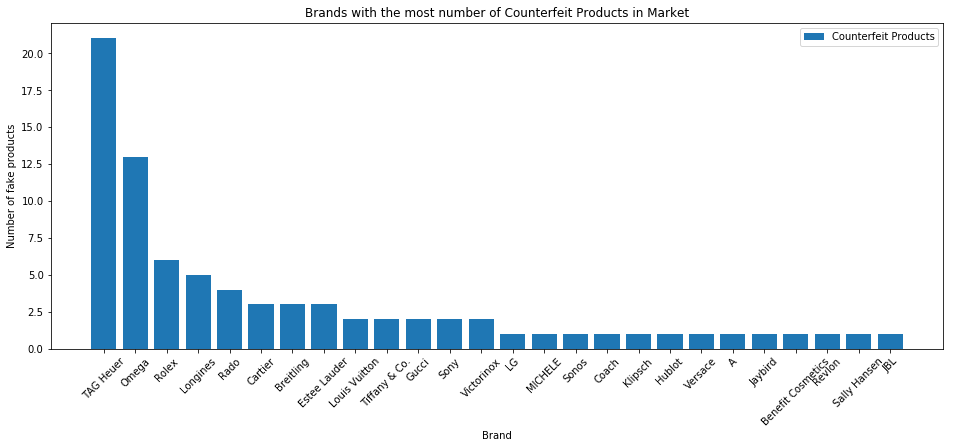

In [25]:
plt.figure(figsize=(16, 6))
plt.bar([x[0] for x in counter], [x[1] for x in counter], label="Counterfeit Products")
plt.title("Brands with the most number of Counterfeit Products in Market")
plt.legend()
plt.xlabel("Brand")
plt.ylabel("Number of fake products")
plt.xticks(rotation=45);

Above Bar graph shows Brands with the most number of Counterfeit products. High end brands on the top of the list

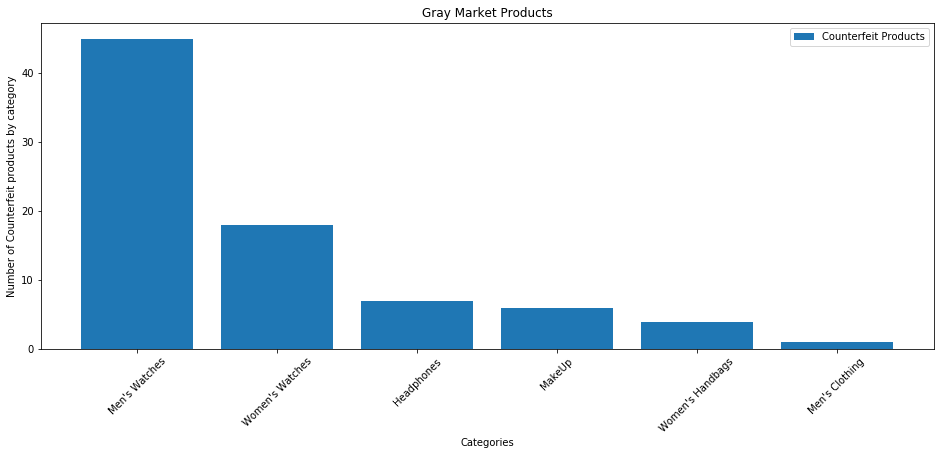

In [26]:
plt.figure(figsize=(16, 6))
plt.bar([x[0] for x in counter_cat], [x[1] for x in counter_cat], label="Counterfeit Products")
plt.title("Gray Market Products")
plt.legend()
plt.xlabel("Categories")
plt.ylabel("Number of Counterfeit products by category")
plt.xticks(rotation=45);

Above Bar graph shows categories with most number of counterfeit items. Watches, followed by Headphone and makeup stuff

### Comparison of counterfeit products vs authentic products

In [36]:
df[df["asin"].isin(fake_sins)].describe()

,helpful_count,num_images,rating,num_comments,list_price,price_low,price_high,lowest_price_new_condition
count,1137.000000,1137.000000,1137.000000,1137.000000,0.0,1137.000000,1137.000000,1137.000000
mean,0.958663,0.054529,3.825858,0.258575,NaN,1052.925004,1052.925004,9.259719
std,6.696979,0.398743,1.542108,0.579870,NaN,8570.480392,8570.480392,19.287112
min,0.000000,0.000000,1.000000,0.000000,NaN,7.950000,7.950000,1.020000
25%,0.000000,0.000000,3.000000,0.000000,NaN,8.400000,8.400000,2.000000
50%,0.000000,0.000000,5.000000,0.000000,NaN,10.770000,10.770000,2.000000
75%,0.000000,0.000000,5.000000,0.000000,NaN,78.000000,78.000000,9.900000
max,148.000000,6.000000,5.000000,6.000000,NaN,156000.000000,156000.000000,156.000000


In [37]:
df[~df["asin"].isin(fake_sins)].describe()

,helpful_count,num_images,rating,num_comments,list_price,price_low,price_high,lowest_price_new_condition
count,357932.000000,357932.000000,357932.000000,357932.000000,12131.000000,255246.000000,255246.000000,34912.000000
mean,0.635403,0.038625,4.247245,0.049174,24.717302,44.283637,44.283637,52.537690
std,6.890763,0.308083,1.248429,0.295239,20.770352,172.256309,172.256309,81.810976
min,0.000000,0.000000,1.000000,0.000000,6.960000,0.010000,0.010000,1.340000
25%,0.000000,0.000000,4.000000,0.000000,12.590000,21.850000,21.850000,15.690000
50%,0.000000,0.000000,5.000000,0.000000,18.920000,34.540000,34.540000,24.990000
75%,0.000000,0.000000,5.000000,0.000000,34.990000,48.950000,48.950000,39.950000
max,968.000000,20.000000,5.000000,39.000000,128.000000,66997.950000,66997.950000,999.990000


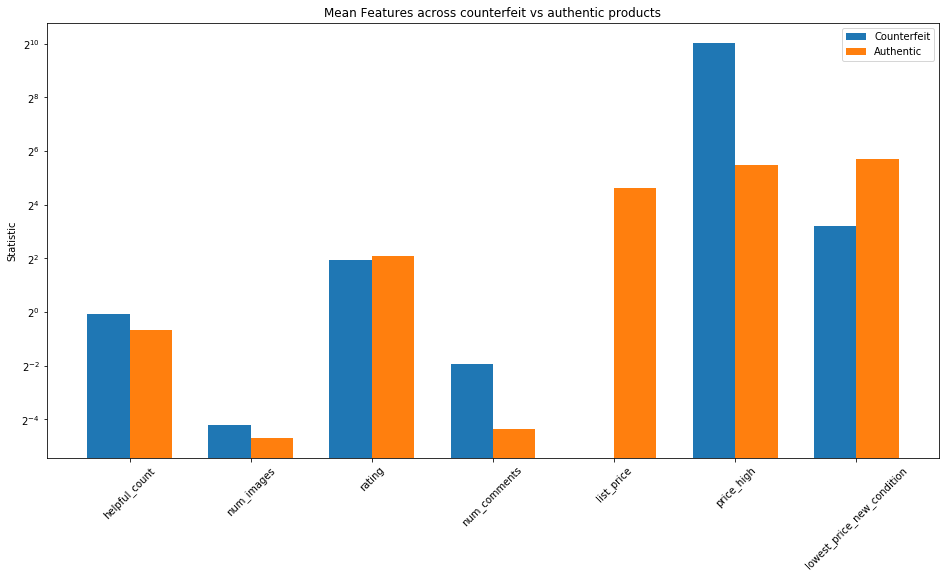

In [68]:
# Below i will create a Bar graph of above two dataframes
tdf = df.copy()
#tdf = tdf.drop(["price_low"], axis=1)
fake_means = tdf[tdf["asin"].isin(fake_sins)].describe().values[1, :]
non_fake_means = tdf[~tdf["asin"].isin(fake_sins)].describe().values[1, :]
N = len(fake_means)
cols = tdf[~tdf["asin"].isin(fake_sins)].describe().columns
plt.figure(figsize=(16, 8))
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, fake_means, width, label='Counterfeit')
plt.bar(ind + width, non_fake_means, width,
    label='Authentic')

plt.ylabel('Statistic')
plt.title('Mean Features across counterfeit vs authentic products')
plt.yscale('log', basey=2)
plt.xticks(ind + width / 2, cols, rotation=45)
plt.legend(loc='best')
plt.show()

### Factors that increases the risk of becoming target of grey market sellers:
    -Price: Higher the price of particular items, higher the risk that item will be targeted by grey marker sellers.
    -Num_comments: Counterfeit items has received more number of comments than Authentic products
                   - Positive feedback will attract more customers
    -Ratings: Difference of rating amond Authentic and Counterfeit items is not much
    -Helpful count: Counterfeit items has received more like on their comments

### Q3 Factors affecting consumer decision
To answer this i will you machine learning, XGboost's feature importance. Here i will use rating as dependent variable. As rating is the variable that describes how satisfied the customers, thus consumer(decision)

In [39]:
train = df.dropna()
train.head()

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,...,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp
706,B00SK72CZ6,RZN13B44MR5ME,"As everyone else stated, it was supposed to be...",2,1,1,2017-08-11,True,False,0,...,False,False,False,True,Amazon.com,Amazon.com,18.92,Dove,3,15
707,B00SK72CZ6,RZLH0YP25FDFY,I have been using this product for years. Comp...,0,0,5,2017-04-19,True,False,0,...,False,False,False,True,Amazon.com,Amazon.com,18.92,Dove,3,15
709,B00SK72CZ6,RZD9W05E2L8MO,"I like Dove products, but I do not like the sm...",0,0,3,2017-01-17,True,False,0,...,False,False,False,True,Amazon.com,Amazon.com,18.92,Dove,3,15
711,B00SK72CZ6,RZ6ANKA9EXG5V,I was really hoping for a body wash that would...,0,0,2,2016-12-09,True,False,1,...,False,False,False,True,Amazon.com,Amazon.com,18.92,Dove,3,15
712,B00SK72CZ6,RZ2NV4HK1YLOR,Good product for older skin.,0,0,5,2016-12-15,True,False,0,...,False,False,False,True,Amazon.com,Amazon.com,18.92,Dove,3,15


In [69]:
# Encoding Categorial features
encoding_reqd = ["is_verified_purchase", "is_vine_voice",
                'is_add_on', 'is_prime', 'is_prime_pantry', 'is_prime_exclusive', 'is_fresh']
for x in encoding_reqd:
    train[x] = LabelEncoder().fit_transform(train[x])

In [70]:
cols = ["helpful_count", "num_images", "rating", "num_comments", "list_price",
        "price_low", "lowest_price_new_condition"] + encoding_reqd
train = train[cols]
train.head(3)

,helpful_count,num_images,rating,num_comments,list_price,price_low,lowest_price_new_condition,is_verified_purchase,is_vine_voice,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh
706,2,1,1,0,18.92,17.97,18.92,1,0,0,1,0,0,0
707,0,0,5,0,18.92,17.97,18.92,1,0,0,1,0,0,0
709,0,0,3,0,18.92,17.97,18.92,1,0,0,1,0,0,0


In [173]:
# importing Xgboost
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(train.drop("rating", axis=1), train["rating"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [174]:
importances = list(zip(model.feature_importances_, train.drop("rating", axis=1).columns.tolist()))
importances.sort(key=lambda x: x[0], reverse=True)

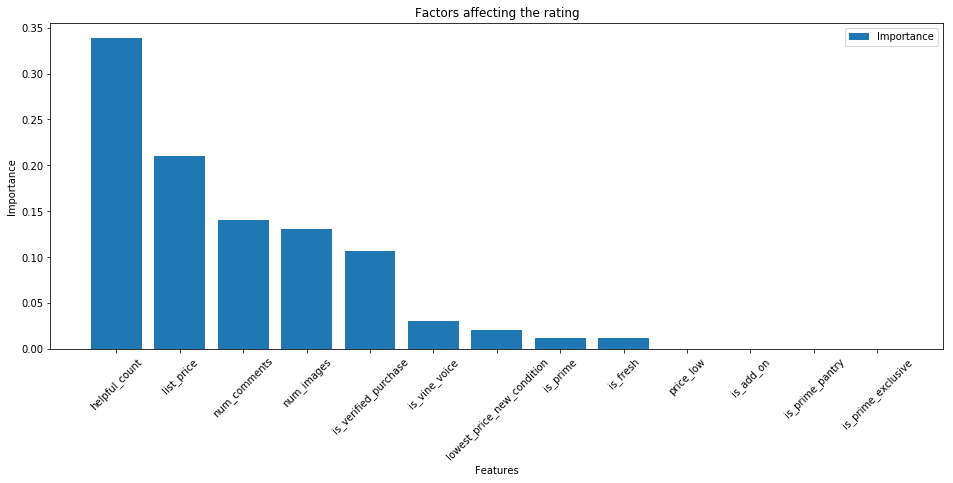

In [212]:
plt.figure(figsize=(16, 6))
plt.bar([x[1] for x in importances], [x[0] for x in importances], label="Importance")
plt.title("Factors affecting the rating")
plt.legend()
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45);

Above bar graph shows important factors that affect consumers decision. Helpful_count, list_price_ comments, images in the description, all affect consumers decision. Product with most number reviews, rating helpfulcount is more likely to sell.

### Q4 how does above Trends between different product categories
looking at the figure in Q2 tells us certain categories are more susceptible to gray marketing than others.
-Here i will use NLP TextBlob to look at the comments, and i will create a graph of consumers sentiment among different categories. 
-And i will use the same XGboost technique i used above to answer question 3 but this time on two different categories, and will see if consumers differs in product categories

In [215]:
from textblob import TextBlob

ctr = 0
def get_sentiment(text):
    global ctr
    ctr += 1
    print("{}/{}\r".format(ctr, len(df)), end="")
    return TextBlob(text).sentiment[0]

df["sentiment"] = df["body"].apply(str).apply(get_sentiment)

In [222]:
stats = {}
for x in df["category"].unique():
    sent = df[df["category"] == x]["sentiment"]
    pos = len(sent[sent > 0.5])
    neg = len(sent[sent < -0.5])
    stats[x] = {"pos": pos, "neg": neg}

In [223]:
stats

{"Women's Shoes": {'pos': 17031, 'neg': 287},
 'Hair Care': {'pos': 1975, 'neg': 77},
 'MakeUp': {'pos': 6591, 'neg': 301},
 'SkinCare': {'pos': 20805, 'neg': 612},
 "Men's Clothing": {'pos': 12268, 'neg': 223},
 'Headphones': {'pos': 2101, 'neg': 79},
 "Men's Watches": {'pos': 1413, 'neg': 30},
 "Women's Watches": {'pos': 526, 'neg': 11},
 "Women's Handbags": {'pos': 595, 'neg': 17},
 "Women's Clothing": {'pos': 5157, 'neg': 107},
 "Men's Shoes": {'pos': 27111, 'neg': 379}}

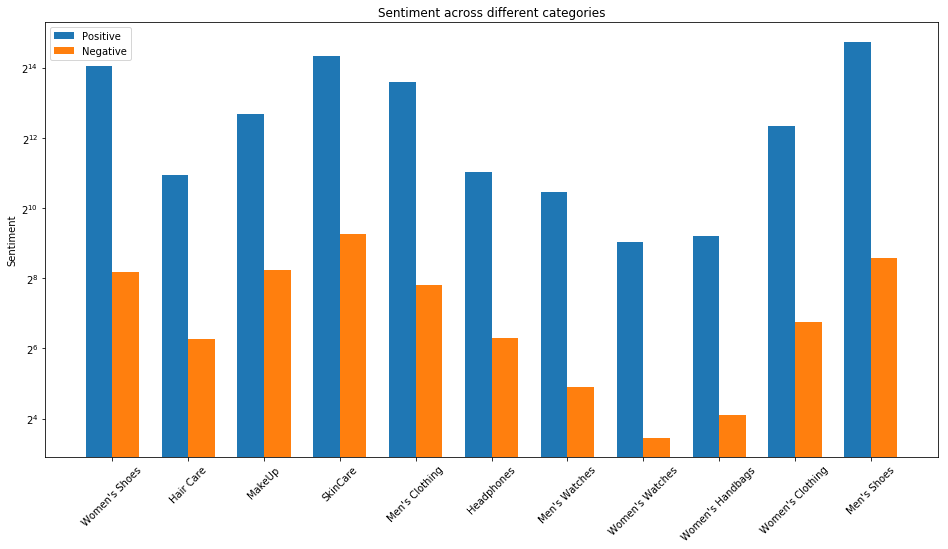

In [283]:
pos = [stats[x]["pos"] for x in stats]
neg = [stats[x]["neg"] for x in stats]
N = len(pos)
plt.figure(figsize=(16, 8))
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, pos, width, label='Positive')
plt.bar(ind + width, neg, width,
    label='Negative')

plt.ylabel('Sentiment')
plt.title('Sentiment across different categories')
plt.yscale('log', basey=2)
plt.xticks(ind + width / 2, stats.keys(), rotation=45)
plt.legend(loc='best')
plt.show()

In [255]:
missing_vals = df.isna().sum()/len(df)
info = pd.DataFrame(missing_vals[missing_vals > 0.1])
info.reset_index(inplace=True)
info.columns = ["Feature", "Missing Value Percent"]
info

,Feature,Missing Value Percent
0,list_price,0.966215
1,price_low,0.285978
2,price_high,0.285978
3,is_add_on,0.226578
4,is_prime,0.226578
5,is_prime_pantry,0.226578
6,is_prime_exclusive,0.226578
7,is_fresh,0.226578
8,has_sns,0.226578
9,offer_fulfiller,0.862492


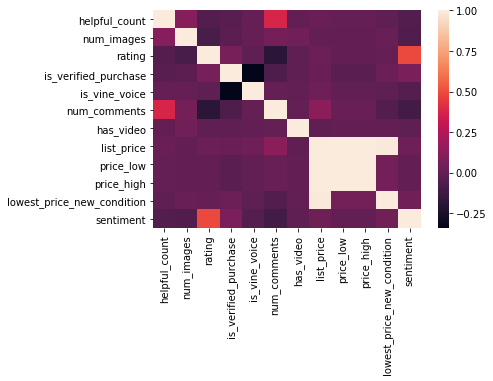

In [256]:
import seaborn as sns

sns.heatmap(df.corr())

In [42]:
notnull = df.dropna()
notnull["category"].value_counts()

MakeUp       3382
Hair Care    1862
SkinCare     1851
Name: category, dtype: int64

In [43]:
train_makeup = notnull[notnull["category"] == "MakeUp"]
train_skin = notnull[notnull["category"] == "SkinCare"]

print(train_makeup.shape)
print(train_skin.shape)

(3382, 27)
(1851, 27)


In [44]:
encoding_reqd = ["is_verified_purchase", "is_vine_voice",
                'is_add_on', 'is_prime', 'is_prime_pantry', 'is_prime_exclusive', 'is_fresh']
for x in encoding_reqd:
    train_makeup[x] = LabelEncoder().fit_transform(train_makeup[x])
    train_skin[x] = LabelEncoder().fit_transform(train_skin[x])

/Users/lucky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/lucky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [282]:
train_skin = train_skin[cols]
train_makeup = train_makeup[cols]

In [284]:
model1 = XGBRegressor()
model1.fit(train_skin.drop("rating", axis=1), train_skin["rating"])

model2 = XGBRegressor()
model2.fit(train_makeup.drop("rating", axis=1), train_makeup["rating"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [285]:
importances1 = list(zip(model1.feature_importances_, train_skin.drop("rating", axis=1).columns.tolist()))
importances1.sort(key=lambda x: x[0], reverse=True)

importances2 = list(zip(model1.feature_importances_, train_makeup.drop("rating", axis=1).columns.tolist()))
importances2.sort(key=lambda x: x[0], reverse=True)



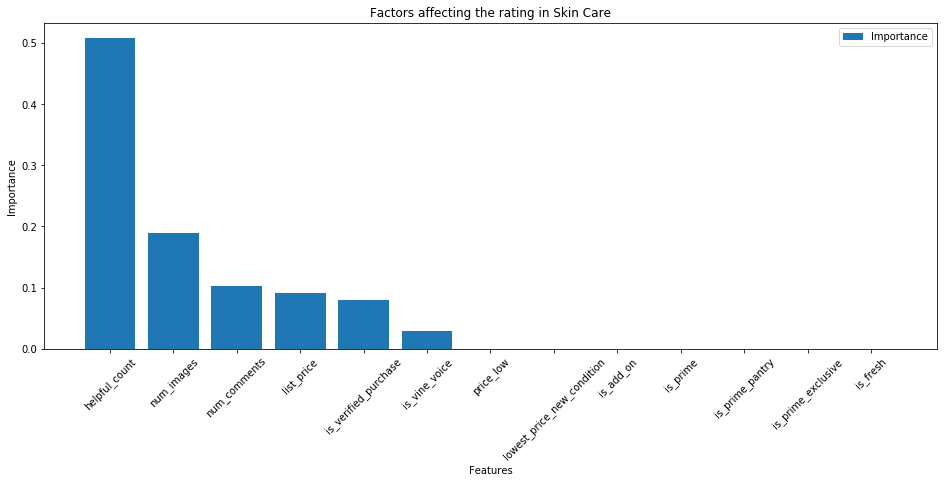

In [286]:
plt.figure(figsize=(16, 6))
plt.bar([x[1] for x in importances1], [x[0] for x in importances1], label="Importance")
plt.title("Factors affecting the rating in Skin Care")
plt.legend()
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45);

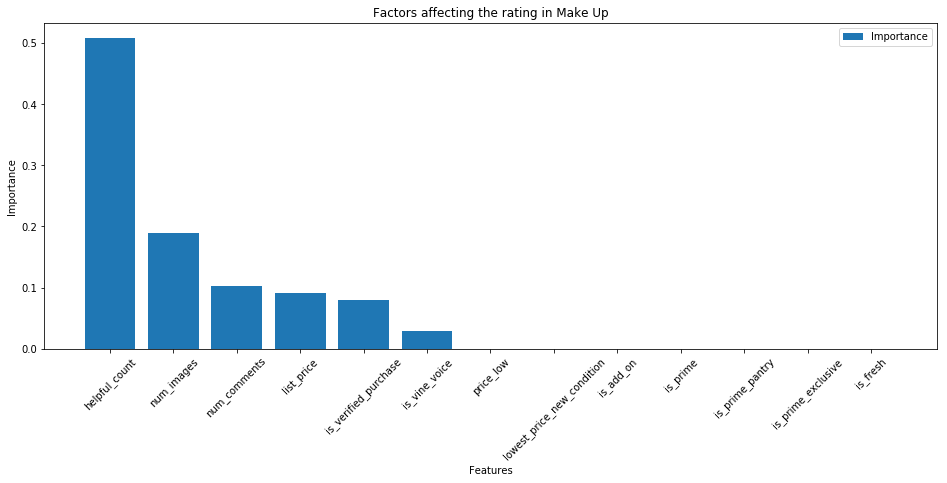

In [287]:
plt.figure(figsize=(16, 6))
plt.bar([x[1] for x in importances2], [x[0] for x in importances2], label="Importance")
plt.title("Factors affecting the rating in Make Up")
plt.legend()
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45);

-Skin case, Men's shoes are their category with most number of negative reviews. <br>
-Consumer decision among two categories above don't differ much